# Load MDL runs

In [1]:
%load_ext autoreload
%autoreload 2


import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

#import data
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Project
from mdldb.run import Run
from mdldb.authenticate import authenticate

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import sys
sys.path.append('../vessel_manoeuvring_models')

In [3]:
#from seaman.simulations.simulation_twin import TwinSimFakeProp,TwinSimFakePropRud
#import twin_simulations
#from seaman.helpers import ShipDict
#from seaman.helpers import subsystem_tree as st
#from seaman.helpers import subsystem_tree_visualization as st_viz
from sklearn.metrics import r2_score
from mlflow_utils import log_mlflow
import vessel_manoeuvring_models.data.mdl as mdl 
#from twin_simulations import preprocess_run

In [4]:
try:
    import plotly.express as px
except:
    !jupyter labextension install jupyterlab-plotly@4.14.3
    
    
import plotly.graph_objects as go

In [5]:
authenticate(dotenv_path='../.env')
db = MDLDataBase()

## Parameters

In [6]:
id = 22610
ship_file_path = r'../inputs/V2_5_R11_MDL.ship'
experiment = 'twin simulation'
iteration = 1
notebook = 'notebook'

In [7]:
run_params = {'experiment': experiment,
              'iteration': iteration,
              'notebook':notebook,
    }

<ipython-input-8-bc6bb137b634>:1: SAWarning: relationship 'Ship.projects' will copy column ships.name to column association.ship_name, which conflicts with relationship(s): 'Project.ships' (copies ships.name to association.ship_name). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   The 'overlaps' parameter may be used to remove this warning.
  run = db.session.query(Run).get(id)
<ipython-input-8-bc6bb137b634>:1: SAWarning: relationship 'Ship.projects' will copy column projects.project_number to column association.project_number, which conflicts with relationship(s): 'Project.ships' (copies projects.project_number to association.project_number). If this is not the intention, consider i

<AxesSubplot:title={'center':'Track plot'}, xlabel='y0 [m]', ylabel='x0 [m]'>

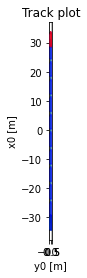

In [8]:
run = db.session.query(Run).get(id)
## Missing in db:
run.xm = 0
run.ym = 0
run.zm = -0.214

run.load()
run.track_plot()

In [9]:
meta_data = {
    'scale_factor' : run.model.scale_factor,
    'lcg' : run.loading_condition.lcg,
    'kg' : run.loading_condition.kg,
    'xm' : run.xm,
    'ym' : run.ym,
    'zm' : run.zm,
}
meta_data = pd.Series(meta_data)
df,units = mdl.preprocess_run(df=run.df, units=run.units, meta_data=meta_data)

In [10]:
columns= list(df.columns)
columns_selected = list(columns)
excludes = ['AP/','Carriage/','Filter/','MOPS/','MA/','KB/','ModelPos/','x_origo','y_origo','z_origo']
for exclude in excludes:
    columns_selected = [key for key in columns_selected if not exclude in key ]
columns_selected

['Arr/Ind/Arr',
 'Arr/Ind/Fri',
 'Fan/Aft/Angle',
 'Fan/Aft/AngleOrder',
 'Fan/Aft/Fx',
 'Fan/Aft/FxOrder',
 'Fan/Aft/Rpm',
 'Fan/Aft/RpmOrder',
 'Fan/ForceFactor',
 'Fan/Fore/Angle',
 'Fan/Fore/AngleOrder',
 'Fan/Fore/Fx',
 'Fan/Fore/FxOrder',
 'Fan/Fore/RpmOrder',
 'Hull/Acc/X1',
 'Hull/Acc/Y1',
 'Hull/Acc/Y2',
 'Hull/Acc/Z1',
 'Hull/Acc/Z2',
 'Hull/Acc/Z3',
 'Prop/PS/Rpm',
 'Prop/PS/Thrust',
 'Prop/PS/Torque',
 'Prop/SB/Rpm',
 'Prop/SB/Thrust',
 'Prop/SB/Torque',
 'delta',
 'Rudder/MaxAngle',
 'Rudder/Rate',
 'Wind/GWA',
 'lab/WaveHeight',
 'roll',
 'pitch',
 'psi',
 'x0',
 'y0',
 'z0']

In [11]:
mask = df['Arr/Ind/Fri'] == 1
df_cut = df.loc[mask].copy()

In [12]:
df_save = df_cut[columns_selected].copy()
save_name = f'{id}.csv'
save_path = os.path.join('../data/raw',save_name)
df_save.to_csv(save_path)

## Now do this for all runs

In [13]:
def process_run(id):
    run = db.session.query(Run).get(id)
    ## Missing in db:
    run.xm = 0
    run.ym = 0
    run.zm = -0.214
    
    run.load()
    
    meta_data = {
    'scale_factor' : run.model.scale_factor,
    'lcg' : run.loading_condition.lcg,
    'kg' : run.loading_condition.kg,
    'xm' : run.xm,
    'ym' : run.ym,
    'zm' : run.zm,
    }
    meta_data = pd.Series(meta_data)
    df,units = mdl.preprocess_run(df=run.df, units=run.units, meta_data=meta_data)
    
    columns= list(df.columns)
    columns_selected = list(columns)
    excludes = ['AP/','Carriage/','Filter/','MOPS/','MA/','KB/','ModelPos/','x_origo','y_origo','z_origo']
    for exclude in excludes:
        columns_selected = [key for key in columns_selected if not exclude in key ]
        
    ## cut:
    mask = df['Arr/Ind/Fri'] == 1
    df_cut = df.loc[mask].copy()
    
    if len(df_cut)==0:
        raise ValueError('Empty run')
        
    df_save = df_cut[columns_selected].copy()
    save_name = f'{id}.csv'
    save_path = os.path.join('../data/raw',save_name)
    df_save.to_csv(save_path)
    
    return units
    

In [14]:
df_select = pd.read_csv('../data/interim/run_selection.csv', index_col=0)

In [15]:
units_all = {}
df_runs = pd.DataFrame()

for id, row in df_select.iterrows():
    
    print(f'process:{id}')
    try:
        units = process_run(id=id)
    except ValueError:
        print('skipping empy run...')
        continue
    
    df_runs = df_runs.append(row)
    units_all.update(units)
    

process:22605
process:22606
process:22607
process:22608
process:22609
process:22610
process:22611
process:22612
process:22613
process:22614
process:22615
process:22616
process:22631
process:22632
process:22633
process:22634
process:22635
process:22636
process:22637
process:22638
process:22639
process:22762
process:22763
process:22764
process:22765
process:22766
skipping empy run...
process:22767
skipping empy run...
process:22768
process:22769
process:22770
process:22771
process:22772
process:22773
process:22774
process:22775
process:22776
process:22777
process:22778
process:22779
process:22780
process:22781
process:22782
process:22813
process:22814
process:22815
process:22816
process:22817
process:22818
process:22819
skipping empy run...
process:22820
skipping empy run...
process:22821
skipping empy run...
process:22822
process:22823
process:22824
process:22825
process:22826
process:22827
process:22828
process:22829
process:22830
process:22831
process:22832
process:22833
process:22834

In [16]:
df_runs.to_csv('../data/raw/runs.csv')

In [17]:
units_path = '../data/raw/units.csv'
units = pd.read_csv(units_path, index_col=0)['0']
units_all = pd.Series(units_all)
units_all = units_all.combine_first(units)
units_all.to_csv(units_path)